In [ ]:
import os
import tensorflow as tf
import numpy as np
import seaborn as sns
import pathlib
# Работа с google диском
from google.colab import drive

# Загрузка датасетов из облака google
import gdown

from IPython import display
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

Нашел датасет на kaggle, который весит около 700 мб, взяла 1/3 часть данных от него с наиболее частовстречающимися словами. Буду работать с этим датасетом

In [ ]:
# Загрузка датасета из облака
#gdown.download('https://drive.google.com/file/d/1Of2chMUmFsOxcFt7Hzmp5ajKUd6dF8Yv/view?usp=sharing', 'mini_speech_commands.zip', quiet=True)

# Распаковка архива в папку data
!unzip -qo mini_speech_commands.zip -d data/


[mini_speech_commands.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of mini_speech_commands.zip or
        mini_speech_commands.zip.zip, and cannot find mini_speech_commands.zip.ZIP, period.


In [ ]:
os.listdir('./data/')

NotADirectoryError: [Errno 20] Not a directory: './data/'

In [ ]:
training_set, validation_set = tf.keras.utils.audio_dataset_from_directory(
	directory='./data/mini_speech_commands',
	batch_size=16,
	validation_split=0.2,
	output_sequence_length=16000,
	seed=0,
	subset='both')

label_names = np.array(training_set.class_names)
print("label names:", label_names)


Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


У меня 8 лейблов, дальше буду работать с ними

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

training_set = training_set.map(squeeze, tf.data.AUTOTUNE)
validation_set = validation_set.map(squeeze, tf.data.AUTOTUNE)


In [ ]:
audio, label = next(iter(training_set))
display.display(display.Audio(audio[0], rate=16000))

Преобразуем сигнал в спектограмму и отрисуем

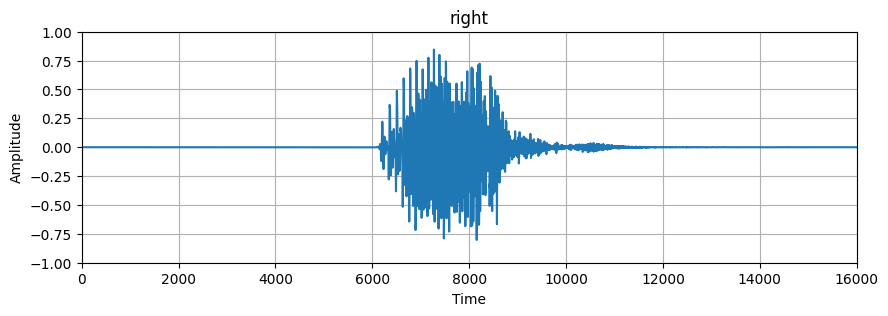

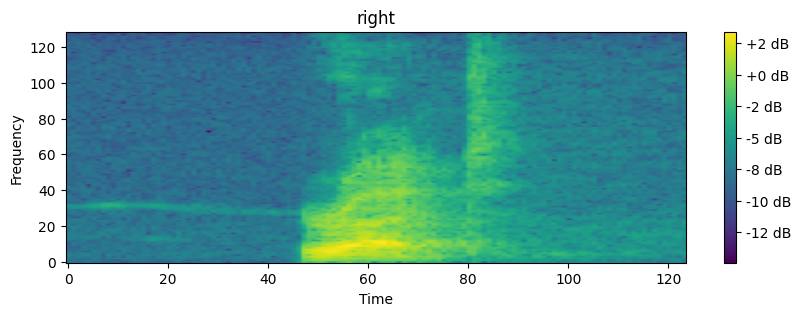

In [ ]:
def plot_wave(waveform, label):
	plt.figure(figsize=(10, 3))
	plt.title(label)
	plt.plot(waveform)
	plt.xlim([0, 16000])
	plt.ylim([-1, 1])
	plt.xlabel('Time')
	plt.ylabel('Amplitude')
	plt.grid(True)

def get_spectrogram(waveform):
	spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
	spectrogram = tf.abs(spectrogram)
	return spectrogram[..., tf.newaxis]

def plot_spectrogram(spectrogram, label):
	spectrogram = np.squeeze(spectrogram, axis=-1)
	log_spec = np.log(spectrogram.T + np.finfo(float).eps)
	plt.figure(figsize=(10, 3))
	plt.title(label)
	plt.imshow(log_spec, aspect='auto', origin='lower')
	plt.colorbar(format='%+2.0f dB')
	plt.xlabel('Time')
	plt.ylabel('Frequency')

audio, label = next(iter(training_set))

plot_wave(audio[0], label_names[label[0]])

plot_spectrogram(get_spectrogram(audio[0]), label_names[label[0]])


Создадим набор данных спектрограммы из аудиосигнала или аудиоданных, разделим выборку

In [ ]:
def get_spectrogram_dataset(dataset):
	dataset = dataset.map(
		lambda x, y: (get_spectrogram(x), y),
		num_parallel_calls=tf.data.AUTOTUNE)
	return dataset

train_set = get_spectrogram_dataset(training_set)
validation_set = get_spectrogram_dataset(validation_set)

val_set = validation_set.take(validation_set.cardinality() // 2)
test_set = validation_set.skip(validation_set.cardinality() // 2)

In [ ]:
train_set_shape = train_set.element_spec[0].shape
val_set_shape = val_set.element_spec[0].shape
test_set_shape = test_set.element_spec[0].shape

print("Train set shape:", train_set_shape)
print("Validation set shape:", val_set_shape)
print("Testing set shape:", test_set_shape)

Train set shape: (None, 124, 129, 1)
Validation set shape: (None, 124, 129, 1)
Testing set shape: (None, 124, 129, 1)


Измененим размер входных данных до квадратного изображения размером 64 x 64 и нормализуем

In [ ]:
def get_model(input_shape, num_labels):
	model = tf.keras.Sequential([
		tf.keras.layers.Input(shape=input_shape),

		tf.keras.layers.Resizing(64, 64),
		tf.keras.layers.Normalization(),

		tf.keras.layers.Conv2D(64, 3, activation='relu'),
		tf.keras.layers.Conv2D(128, 3, activation='relu'),
		tf.keras.layers.MaxPooling2D(),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
		tf.keras.layers.Dropout(0.5),
		tf.keras.layers.Dense(num_labels, activation='softmax')
	])

	model.summary()
	return model

input_shape = next(iter(train_set))[0][0].shape
print("Input shape:", input_shape)
num_labels = len(label_names)

# Creating a model
model = get_model(input_shape, num_labels)

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizati  (None, 64, 64, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [ ]:
model.compile(
	optimizer=tf.keras.optimizers.Adam(),
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=['accuracy'],
)

EPOCHS = 10
history = model.fit(
	train_set,
	validation_data=val_set,
	epochs=EPOCHS,
)

Epoch 1/10
400/400 [==============================] - 17s 26ms/step - loss: 1.6617 - accuracy: 0.3852 - val_loss: 1.0495 - val_accuracy: 0.6475
Epoch 2/10
400/400 [==============================] - 10s 25ms/step - loss: 1.0028 - accuracy: 0.6531 - val_loss: 0.6864 - val_accuracy: 0.7975
Epoch 3/10
400/400 [==============================] - 10s 24ms/step - loss: 0.7218 - accuracy: 0.7509 - val_loss: 0.5672 - val_accuracy: 0.8163
Epoch 4/10
400/400 [==============================] - 11s 28ms/step - loss: 0.5865 - accuracy: 0.7966 - val_loss: 0.4964 - val_accuracy: 0.8250
Epoch 5/10
400/400 [==============================] - 11s 27ms/step - loss: 0.4817 - accuracy: 0.8358 - val_loss: 0.4171 - val_accuracy: 0.8675
Epoch 6/10
400/400 [==============================] - 12s 30ms/step - loss: 0.4504 - accuracy: 0.8477 - val_loss: 0.4187 - val_accuracy: 0.8575
Epoch 7/10
400/400 [==============================] - 10s 25ms/step - loss: 0.3730 - accuracy: 0.8684 - val_loss: 0.4066 - val_accuracy:

Text(0, 0.5, 'Accuracy')

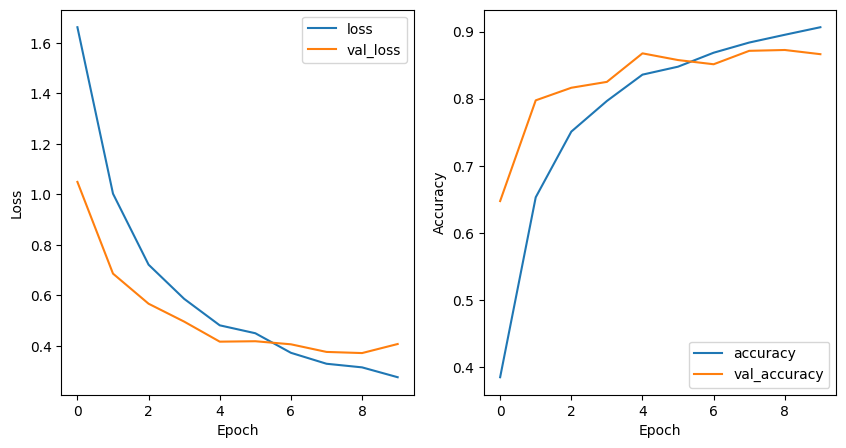

In [ ]:
metrics = history.history
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Отрисуем матрицу ошибок

50/50 [==============================] - 1s 14ms/step


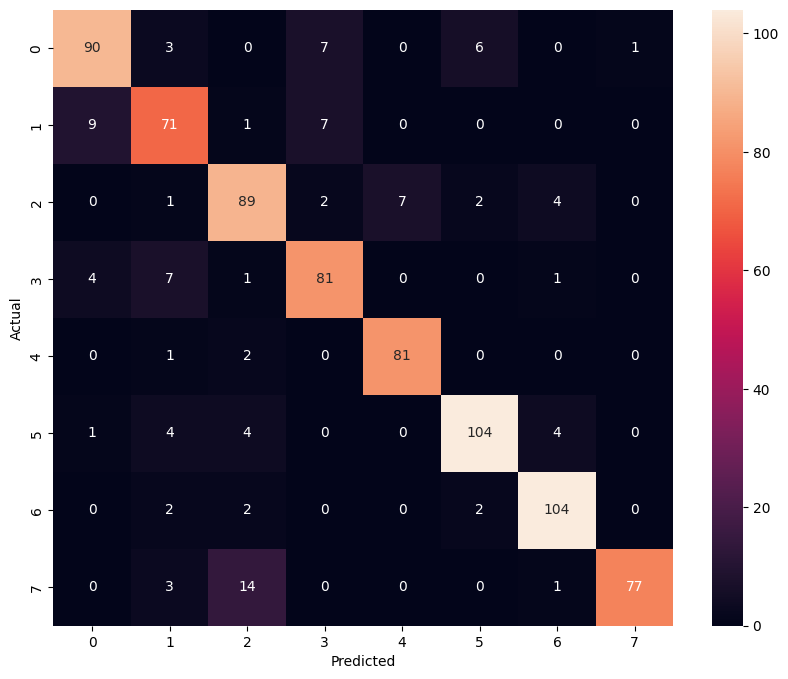

In [ ]:
y_pred = np.argmax(model.predict(test_set), axis=1)
y_true = np.concatenate([y for x, y in test_set], axis=0)
cm = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       107
           1       0.77      0.81      0.79        88
           2       0.79      0.85      0.82       105
           3       0.84      0.86      0.85        94
           4       0.92      0.96      0.94        84
           5       0.91      0.89      0.90       117
           6       0.91      0.95      0.93       110
           7       0.99      0.81      0.89        95

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800



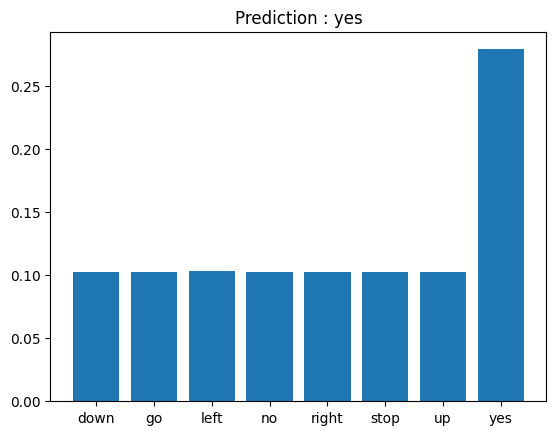

In [ ]:
path = 'data/mini_speech_commands/yes/004ae714_nohash_0.wav'
Input = tf.io.read_file(str(path))
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,)
audio, labels = squeeze(x, 'yes')

waveform = audio
display.display(display.Audio(waveform, rate=16000))

x = get_spectrogram(audio)
x = tf.expand_dims(x, axis=0)

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()])
plt.show()

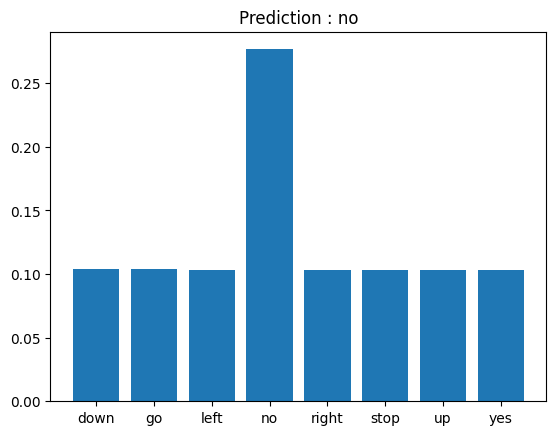

In [ ]:
path = '/content/data/mini_speech_commands/no/0132a06d_nohash_3.wav'
Input = tf.io.read_file(str(path))
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,)
audio, labels = squeeze(x, 'no')

waveform = audio
display.display(display.Audio(waveform, rate=16000))

x = get_spectrogram(audio)
x = tf.expand_dims(x, axis=0)

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()])
plt.show()

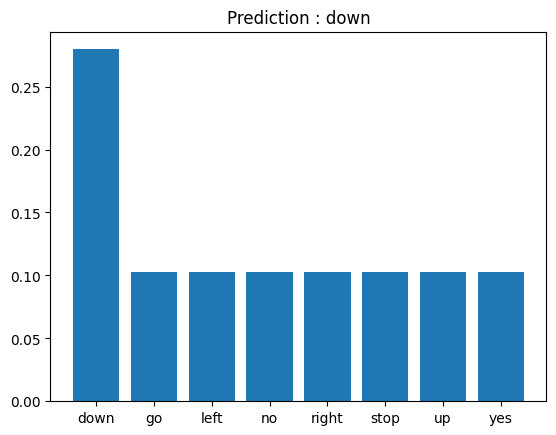

In [ ]:
path = '/content/data/mini_speech_commands/down/0132a06d_nohash_4.wav'
Input = tf.io.read_file(str(path))
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,)
audio, labels = squeeze(x, 'down')

waveform = audio
display.display(display.Audio(waveform, rate=16000))

x = get_spectrogram(audio)
x = tf.expand_dims(x, axis=0)

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()])
plt.show()

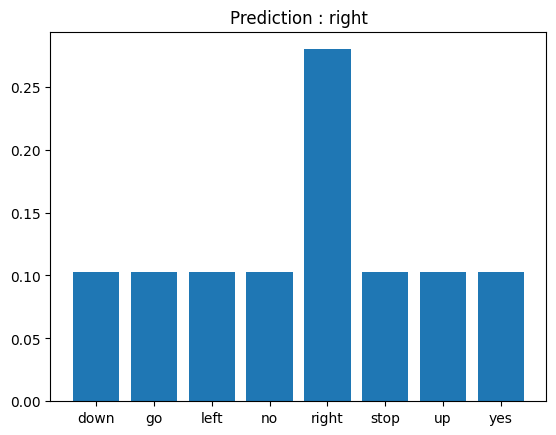

In [ ]:
path = '/content/data/mini_speech_commands/right/0132a06d_nohash_2.wav'
Input = tf.io.read_file(str(path))
x, sample_rate = tf.audio.decode_wav(Input, desired_channels=1, desired_samples=16000,)
audio, labels = squeeze(x, 'right')

waveform = audio
display.display(display.Audio(waveform, rate=16000))

x = get_spectrogram(audio)
x = tf.expand_dims(x, axis=0)

prediction = model(x)
plt.bar(label_names, tf.nn.softmax(prediction[0]))
plt.title('Prediction : '+label_names[np.argmax(prediction, axis=1).item()])
plt.show()